In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer



In [2]:
# Load the dataset
url = 'https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv'
df = pd.read_csv(url)


In [3]:

# Lowercase column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Remove the 'student_id' column
df = df.drop('student_id', axis=1)

# Fill missing values with zeros
df = df.fillna(0)

# Split the dataset into train, validation, and test sets with a 60%/20%/20% distribution
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

# Separate target variable ('jamb_score') and remove it from feature sets
y_train = df_train['jamb_score'].values
y_val = df_val['jamb_score'].values
y_test = df_test['jamb_score'].values

X_train = df_train.drop('jamb_score', axis=1)
X_val = df_val.drop('jamb_score', axis=1)
X_test = df_test.drop('jamb_score', axis=1)

# Convert dataframes to dictionaries and use DictVectorizer to transform them into matrices
dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))
X_test = dv.transform(X_test.to_dict(orient='records'))


# Question 1

In [4]:
from sklearn.tree import DecisionTreeRegressor

# Train a Decision Tree Regressor with max_depth=1
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

# Get the feature used for splitting
feature_index = dt.tree_.feature[0]  # Index of the splitting feature
split_feature = dv.feature_names_[feature_index]  # Feature name based on DictVectorizer

split_feature


'study_hours_per_week'

# Question 2

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Train a Random Forest Regressor with the given parameters
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = rf.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
rmse


43.157758977963624

# Question 3

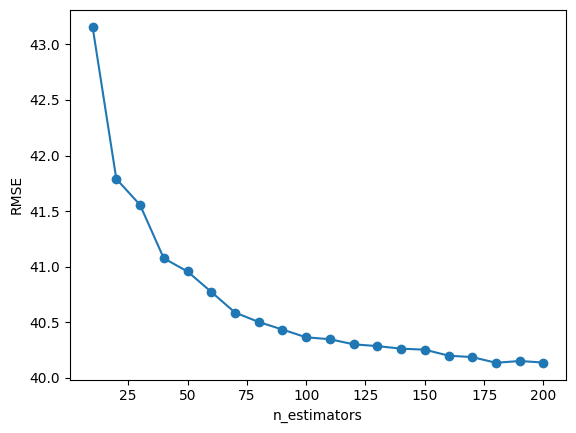

190

In [10]:
# List to store RMSE scores
rmse_scores = []

# Loop through each value of n_estimators and calculate RMSE
for n in range(10, 210, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_val = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    rmse_scores.append((n, round(rmse, 3)))  # Round RMSE to 3 decimal points

# Plot RMSE scores
n_values, rmse_values = zip(*rmse_scores)
plt.plot(n_values, rmse_values, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.show()

# Identify the latest point where RMSE stops improving
n_stabilizes = None
for i in range(1, len(rmse_values)):
    if rmse_values[i] >= rmse_values[i - 1]:  # No further improvement
        n_stabilizes = n_values[i]
        break

n_stabilizes = n_stabilizes if n_stabilizes is not None else n_values[-1]
n_stabilizes


# Question 4

In [12]:
# Initialize variables to store results
results = []

# Loop through each max_depth and n_estimators
for max_depth in [10, 15, 20, 25]:
    rmse_values = []
    
    for n in range(10, 210, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        # Predict on the validation set and calculate RMSE
        y_pred_val = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        rmse_values.append(rmse)
    
    # Calculate mean RMSE for the current max_depth
    mean_rmse = np.mean(rmse_values)
    results.append((max_depth, mean_rmse))

# Find the max_depth with the lowest mean RMSE
best_max_depth, best_mean_rmse = min(results, key=lambda x: x[1])

best_max_depth


10

# Question 5

In [13]:
# Train the Random Forest model with specified parameters
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Extract feature importances
importances = rf.feature_importances_
feature_names = dv.get_feature_names_out()

# Create a dictionary of feature names and their importances, then sort it
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the most important feature among the specified ones
for feature, importance in sorted_features:
    if feature in ['study_hours_per_week', 'attendance_rate', 'distance_to_school', 'teacher_quality']:
        print(f"{feature}: {importance}")
        break


study_hours_per_week: 0.25407520246568593


# Question 6

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Create DMatrix for training and validation
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Create a watchlist to monitor the training and validation error
watchlist = [(dtrain, 'train'), (dval, 'val')]

# Define XGBoost parameters
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Function to train XGBoost model and return best RMSE on validation
def train_xgb(eta):
    params = xgb_params.copy()
    params['eta'] = eta
    model = xgb.train(params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10, verbose_eval=False)
    
    # Get the best RMSE on the validation set
    best_rmse = np.sqrt(mean_squared_error(y_val, model.predict(dval)))
    return best_rmse

# Train models with eta=0.3 and eta=0.1
rmse_eta_03 = train_xgb(0.3)
rmse_eta_01 = train_xgb(0.1)

# Compare RMSE scores
best_eta = 0.3 if rmse_eta_03 < rmse_eta_01 else 0.1
best_eta


0.1